### Importing libraries

In [10]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Configuring hardware

In [11]:
physical_devices = tf.config.list_physical_devices()

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

### Loading data

##### Processed dataset with pre-selecter features (by Random Forest)

In [13]:
# data_train = pd.read_csv('data/processed/train_meaningfull.csv')
# data_test = pd.read_csv('data/processed/test_meaningfull.csv')

##### Raw dataset with (>500 features)

In [14]:
data_train = pd.read_csv('data/raw/train.csv')
data_test = pd.read_csv('data/raw/test.csv')

##### Processing data

In [15]:
X_train = data_train.drop('Activity', axis='columns')
y_train = data_train['Activity']
y_train_encoded = pd.get_dummies(y_train)

In [16]:
X_test = data_test.drop('Activity', axis='columns')
y_test = data_test['Activity']
y_test_encoded = pd.get_dummies(y_test)

### Build model

In [17]:
from tensorflow import keras
from keras import regularizers
from keras import layers

regularizer = regularizers.l2(l=0.01)

model = keras.Sequential(
  [
    layers.Input(X_train.shape[-1]),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.15),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(384, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.35),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.4),
    layers.Dense(6, activation="sigmoid"),
  ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               72064     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 384)               98688     
                                                                 
 dropout_7 (Dropout)         (None, 384)               0         
                                                                 
 dense_9 (Dense)             (None, 256)              

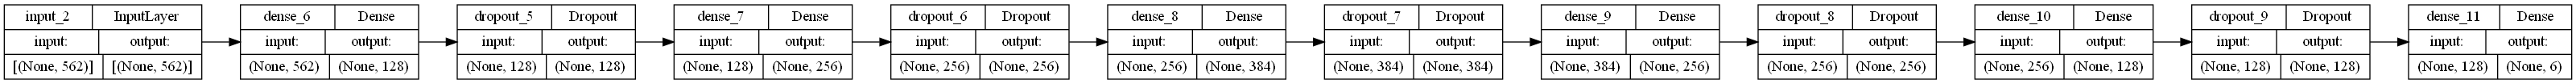

In [18]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [19]:
optimizer = keras.optimizers.Adadelta(learning_rate=2e-1, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics='accuracy')

### Train model

#### Save checkpoint

In [20]:
CHECKPOINT_PATH = 'models/checkpoints/dnn_best.keras'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

In [21]:
%%time
history = model.fit(
  X_train,
  y_train_encoded,
  batch_size=1000,
  epochs=500,
  verbose=1,
  validation_split=0.3,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/500
6/6 [==============================] - 2s 80ms/step - loss: 13.4957 - accuracy: 0.1869 - val_loss: 13.2398 - val_accuracy: 0.1958
Epoch 2/500
6/6 [==============================] - 0s 39ms/step - loss: 13.3043 - accuracy: 0.2081 - val_loss: 13.0855 - val_accuracy: 0.3445
Epoch 3/500
6/6 [==============================] - 0s 18ms/step - loss: 13.1280 - accuracy: 0.2312 - val_loss: 12.9189 - val_accuracy: 0.3422
Epoch 4/500
6/6 [==============================] - 0s 28ms/step - loss: 12.9491 - accuracy: 0.2571 - val_loss: 12.7183 - val_accuracy: 0.3604
Epoch 5/500
6/6 [==============================] - 0s 25ms/step - loss: 12.7699 - accuracy: 0.2880 - val_loss: 12.5098 - val_accuracy: 0.4991
Epoch 6/500
6/6 [==============================] - 0s 25ms/step - loss: 12.5857 - accuracy: 0.3063 - val_loss: 12.3037 - val_accuracy: 0.5372
Epoch 7/500
6/6 [==============================] - 0s 26ms/step - loss: 12.4104 - accuracy: 0.3360 - val_loss: 12.1034 - val_accuracy: 0.5653
Epoch 

### Evaluate model performance

In [22]:
best_checkpoint = keras.models.load_model(CHECKPOINT_PATH)

loss, score = best_checkpoint.evaluate(X_test, y_test_encoded)

print(score)

93/93 [==============================] - 1s 4ms/step - loss: 0.7155 - accuracy: 0.9386
0.9385815858840942


Text(0.5, 1.0, 'Accuracy Curves')

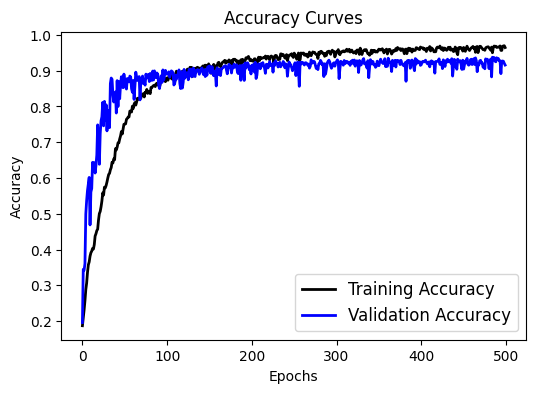

In [23]:
# Plotting the accuracy curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)